# 1. Setup

In [1]:
pip install hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.8/583.8 kB 4.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for humbug>=0.3.1 from https://files.pythonhosted.org/packages/c8/cc/c8129d6e9a1f473b5e90cf1b8eac43191a22657b9b673e02815548662270/humbug-0.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for libdeeplake==0.0.92 from https://files.pythonhosted.org/packages/62/6a/b0fe2c1e80eb00a6077be893f5a942343cc69e34e9d413c078f621bba9c8/libdeeplake-0.0.92-cp310-cp310-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for aioboto3>=10.4.0 from https://files.pythonhosted.org/packages/75/50/e56cabec21ee746e7245d0a3d87f4e8c788b5249486ad1351dbfc01249ff/aioboto3-12.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for boto3 from https://files.pythonhosted.org/packages/81/bf/1dccda444cede321eafc7ae88038

In [2]:
pip uninstall opencv-python-headless -y 

Found existing installation: opencv-python-headless 4.8.1.78
Uninstalling opencv-python-headless-4.8.1.78:
  Successfully uninstalled opencv-python-headless-4.8.1.78
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python --upgrade

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/d9/64/7fdfb9386511cd6805451e012c537073a79a958a58795c4e602e538c388c/opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 19.0 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.1.78
    Uninstalling opencv-python-4.8.1.78:
      Successfully uninstalled opencv-python-4.8.1.78
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.0 MB/s eta 0:00:00a 0:00:010m
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/

### 1.1 Import TF and Deps

In [5]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
import torch
import os
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model

### 1.2 Limit GPU Memory Growth

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# 2. Augmentation

In [9]:
import albumentations as alb

In [10]:
augmentor = alb.Compose([alb.Resize(width=600, height=600),
                         alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

# 3. Get dataset

In [11]:
import deeplake
ds_train = deeplake.load("hub://activeloop/celeb-a-train")[:10000]
ds_val = deeplake.load("hub://activeloop/celeb-a-train")[10000:13000]
ds_test = deeplake.load("hub://activeloop/celeb-a-test")[:1000]

/

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/celeb-a-train



-

hub://activeloop/celeb-a-train loaded successfully.



/opt/conda/lib/python3.10/site-packages/deeplake/api/dataset.py:743: UserWarning: Dataset has more than 20 tensors. Skipping integrity check. Specify `check_integrity=True` to perform integrity check.
  warnings.warn(

|

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/celeb-a-train



\

hub://activeloop/celeb-a-train loaded successfully.



|

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/celeb-a-test



hub://activeloop/celeb-a-test loaded successfully.



In [12]:
ds = {}
ds['train'] = ds_train
ds['test'] = ds_test
ds['val'] = ds_val

In [13]:
import torch
import os
import cv2
for partition in ['train','test','val']: 
    print(partition)
    for idx in range(len(ds[partition]['images'])):
        img = np.array(ds[partition]['images'][idx])
        coords = [0, 0, 0.0001, 0.0001]
        label = np.array(ds[partition]['boxes'][idx])[0]
        
        coords[0] = label[0] # xmin
        coords[1] = label[1] # ymin
        w = label[2]
        h = label[3]
        coords[2] = w + label[0] # w + xmin
        coords[3] = h + label[1] # h + ymin
        coords = list(np.divide(coords, [img.shape[1], img.shape[0], img.shape[1], img.shape[0]]))
        try: 
            augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

            file_path = os.path.join('/kaggle/working/aug_data', partition, 'images', f'{idx}.jpg')

            # Check if the directory exists, if not, create it
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)

            cv2.imwrite(os.path.join('/kaggle/working/aug_data', partition, 'images', f'{idx}.jpg'), augmented['image'])

            annotation = {}
            annotation['image'] = idx

            if len(augmented['bboxes']) == 0: 
                annotation['bbox'] = [0,0,0,0]
                annotation['class'] = 0 
            else: 
                annotation['bbox'] = augmented['bboxes'][0]
                annotation['class'] = 1

            file_path = os.path.join('/kaggle/working/aug_data', partition, 'labels', f'{idx}.json')

            # Check if the directory exists, if not, create it
            directory = os.path.dirname(file_path)
            if not os.path.exists(directory):
                os.makedirs(directory)

            # Write the JSON object to the file
            with open(file_path, 'w') as f:
                json.dump(annotation, f)
        except Exception as e:
            print(idx)
            print(e)

train
2916
x_max is less than or equal to x_min for bbox [0.16666666666666666, 0.7666666666666667, 0.16666666666666666, 0.7666666666666667, 'face'].
test
val


# 4. Load Augmented Images & label to Tensorflow Dataset

In [14]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [15]:
train_images = tf.data.Dataset.list_files('/kaggle/working/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [16]:
test_images = tf.data.Dataset.list_files('/kaggle/working/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [17]:
val_images = tf.data.Dataset.list_files('/kaggle/working/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [18]:
train_images.as_numpy_iterator().next()

array([[[0.3685662 , 0.66954654, 0.85729164],
        [0.35422793, 0.6576593 , 0.8514706 ],
        [0.25539216, 0.46666667, 0.7764706 ],
        ...,
        [0.8143995 , 0.9090074 , 0.9643995 ],
        [0.5311887 , 0.746875  , 0.8356005 ],
        [0.334375  , 0.6353554 , 0.76329654]],

       [[0.38284314, 0.6838235 , 0.8715686 ],
        [0.35637254, 0.6598039 , 0.85134804],
        [0.25539216, 0.46666667, 0.7756128 ],
        ...,
        [0.8108456 , 0.90539217, 0.96096814],
        [0.54944855, 0.7637868 , 0.85294116],
        [0.3428309 , 0.63351715, 0.76390934]],

       [[0.37481618, 0.67971814, 0.8556985 ],
        [0.35594362, 0.659375  , 0.84319854],
        [0.2583946 , 0.4696691 , 0.7716299 ],
        ...,
        [0.8151961 , 0.9014706 , 0.96862745],
        [0.5593137 , 0.7676471 , 0.8598039 ],
        [0.34105393, 0.627451  , 0.7599878 ]],

       ...,

       [[0.2023897 , 0.3949142 , 0.5408088 ],
        [0.21758579, 0.40827206, 0.53768384],
        [0.17297794, 0

In [19]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [20]:
train_labels = tf.data.Dataset.list_files('/kaggle/working/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [21]:
test_labels = tf.data.Dataset.list_files('/kaggle/working/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [22]:
val_labels = tf.data.Dataset.list_files('/kaggle/working/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [23]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2261, 0.18  , 0.9185, 1.    ], dtype=float16))

# 6. Create batch

In [24]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(9999, 9999, 1000, 1000, 3000, 3000)

In [25]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [26]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [27]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [28]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4485 , 0.1063 , 0.995  , 0.6006 ],
        [0.     , 0.1392 , 0.848  , 0.965  ],
        [0.3286 , 0.1332 , 1.     , 0.6343 ],
        [0.3557 , 0.537  , 0.852  , 1.     ],
        [0.552  , 0.0994 , 0.968  , 0.9937 ],
        [0.2534 , 0.4956 , 0.6753 , 1.     ],
        [0.231  , 0.03333, 1.     , 0.8867 ],
        [0.0411 , 0.2937 , 0.588  , 1.     ]], dtype=float16))

In [29]:
data_samples = train.as_numpy_iterator()

In [30]:
res = data_samples.next()

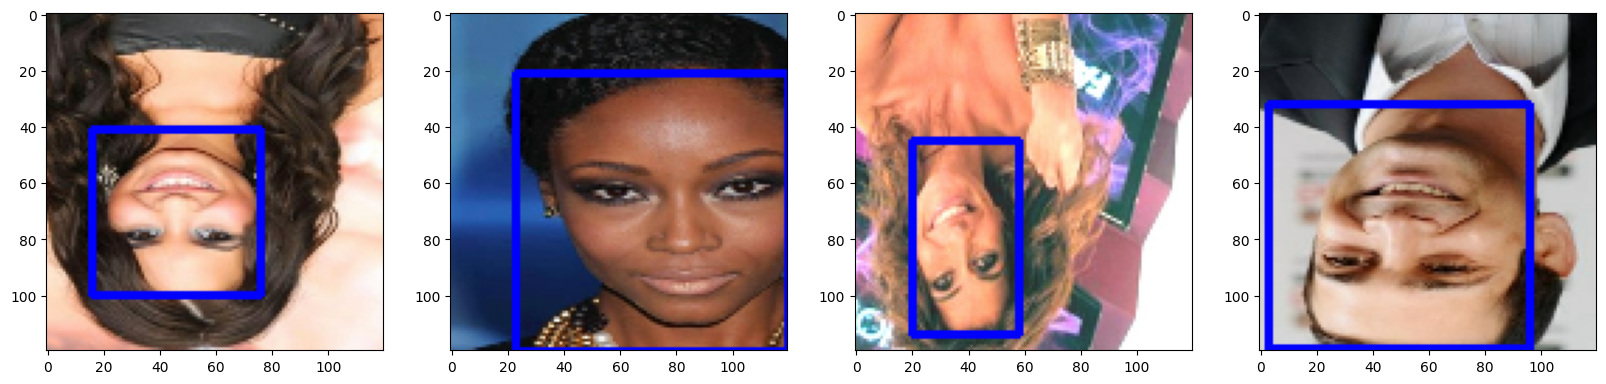

In [34]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
    sample_image = np.copy(res[0][idx])  # Create a copy of the image
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                  (255, 0, 0), 2)
    
    # Convert BGR to RGB
    sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    ax[idx].imshow(sample_image_rgb)
    
plt.show()


# 7. Defince model

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [36]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [37]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [38]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [39]:
facetracker = build_model()

In [40]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [41]:
X, y = train.as_numpy_iterator().next()

In [42]:
X.shape

(8, 120, 120, 3)

In [43]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 7s 7s/step


In [44]:
classes, coords

(array([[0.32652435],
        [0.30460057],
        [0.39412853],
        [0.33777827],
        [0.3380312 ],
        [0.3187727 ],
        [0.3702042 ],
        [0.3525277 ]], dtype=float32),
 array([[0.46114168, 0.43863878, 0.64739084, 0.4916265 ],
        [0.5527064 , 0.50842476, 0.7140684 , 0.50754213],
        [0.51882213, 0.4090517 , 0.7079098 , 0.4054909 ],
        [0.5827372 , 0.44443485, 0.68691087, 0.39886567],
        [0.49214086, 0.4551832 , 0.571142  , 0.4982153 ],
        [0.5100604 , 0.55936986, 0.6454491 , 0.43354857],
        [0.5389798 , 0.4763773 , 0.64150184, 0.48675114],
        [0.5317445 , 0.5034547 , 0.6132547 , 0.47261658]], dtype=float32))

In [45]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [46]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [47]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [48]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [49]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.4789133>

In [50]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0735834>

In [51]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.4789133>

In [52]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [53]:
model = FaceTracker(facetracker)

In [54]:
model.compile(opt, classloss, regressloss)

In [55]:
logdir='logs'

In [56]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# 8. Train

In [57]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
1250/1250 [==============================] - 95s 64ms/step - total_loss: 0.3477 - class_loss: 0.0145 - regress_loss: 0.3405 - val_total_loss: 0.0801 - val_class_loss: 1.0191e-04 - val_regress_loss: 0.0800
Epoch 2/10
1250/1250 [==============================] - 85s 64ms/step - total_loss: 0.1620 - class_loss: 0.0101 - regress_loss: 0.1569 - val_total_loss: 0.0661 - val_class_loss: 6.7069e-05 - val_regress_loss: 0.0661
Epoch 3/10
1250/1250 [==============================] - 87s 65ms/step - total_loss: 0.1167 - class_loss: 0.0089 - regress_loss: 0.1122 - val_total_loss: 0.0717 - val_class_loss: 5.6476e-06 - val_regress_loss: 0.0717
Epoch 4/10
1250/1250 [==============================] - 87s 65ms/step - total_loss: 0.0992 - class_loss: 0.0057 - regress_loss: 0.0964 - val_total_loss: 0.1661 - val_class_loss: 1.1921e-07 - val_regress_loss: 0.1661
Epoch 5/10
1250/1250 [==============================] - 87s 65ms/step - total_loss: 0.0841 - class_loss: 0.0074 - regress_loss: 0.0804 -

In [58]:
hist.history

{'total_loss': [0.06450413912534714,
  0.04241586849093437,
  0.1943591982126236,
  0.06512687355279922,
  0.1681872457265854,
  0.0473533496260643,
  0.059973884373903275,
  0.02606349252164364,
  0.07072992622852325,
  0.05499478057026863],
 'class_loss': [1.7200229649461107e-06,
  5.143109319760697e-06,
  0.0002261714544147253,
  1.1069477068303968e-06,
  0.007968222722411156,
  1.2909149518236518e-05,
  0.00038792731356807053,
  1.5326916980029637e-07,
  4.430161789059639e-05,
  7.108344289008528e-05],
 'regress_loss': [0.06450328230857849,
  0.04241329804062843,
  0.1942461133003235,
  0.06512632220983505,
  0.16420313715934753,
  0.047346893697977066,
  0.05977991968393326,
  0.02606341615319252,
  0.0707077756524086,
  0.054959237575531006],
 'val_total_loss': [0.08007624000310898,
  0.06608789414167404,
  0.07166842371225357,
  0.16614249348640442,
  0.12812428176403046,
  0.039842456579208374,
  0.06059414520859718,
  0.11268294602632523,
  0.05978104844689369,
  0.05888632684

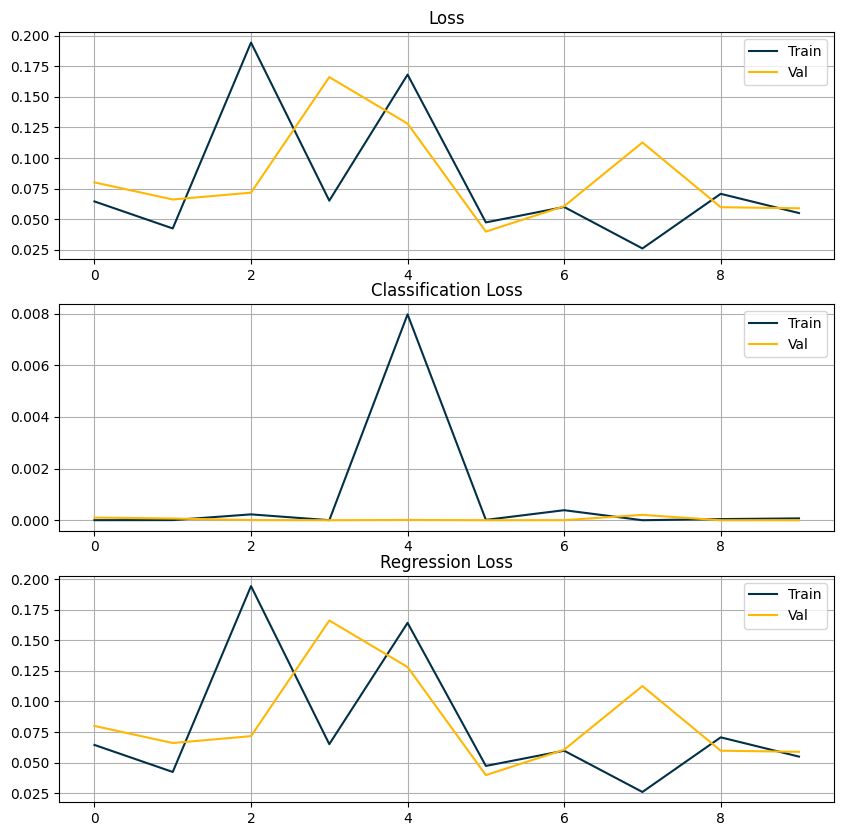

In [83]:
fig, ax = plt.subplots(nrows=3, figsize=(10, 10))  # 1 cột, 3 hàng

color = ['#023047', '#ffb703']
y1 = hist.history['total_loss']
y2 = hist.history['val_total_loss']
ax[0].plot(y1, color= color[0], label='Train')
ax[0].plot(y2, color= color[1], label='Val')
ax[0].title.set_text('Loss')
ax[0].legend()
ax[0].grid(True)

y1 = hist.history['class_loss']
y2 = hist.history['val_class_loss']
ax[1].plot(y1, color= color[0], label='Train')
ax[1].plot(y2, color= color[1], label='Val')
ax[1].title.set_text('Classification Loss')
ax[1].legend()
ax[1].grid(True)

y1 = hist.history['regress_loss']
y2 = hist.history['val_regress_loss']
ax[2].plot(y1, color= color[0], label='Train')
ax[2].plot(y2, color= color[1], label='Val')
ax[2].title.set_text('Regression Loss')
ax[2].legend()
ax[2].grid(True)

plt.show()

# 9. Make Predictions

### 9.1. Make Predictions on Test Set

In [60]:
test_data = test.as_numpy_iterator()

In [61]:
test_sample = test_data.next()

In [62]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


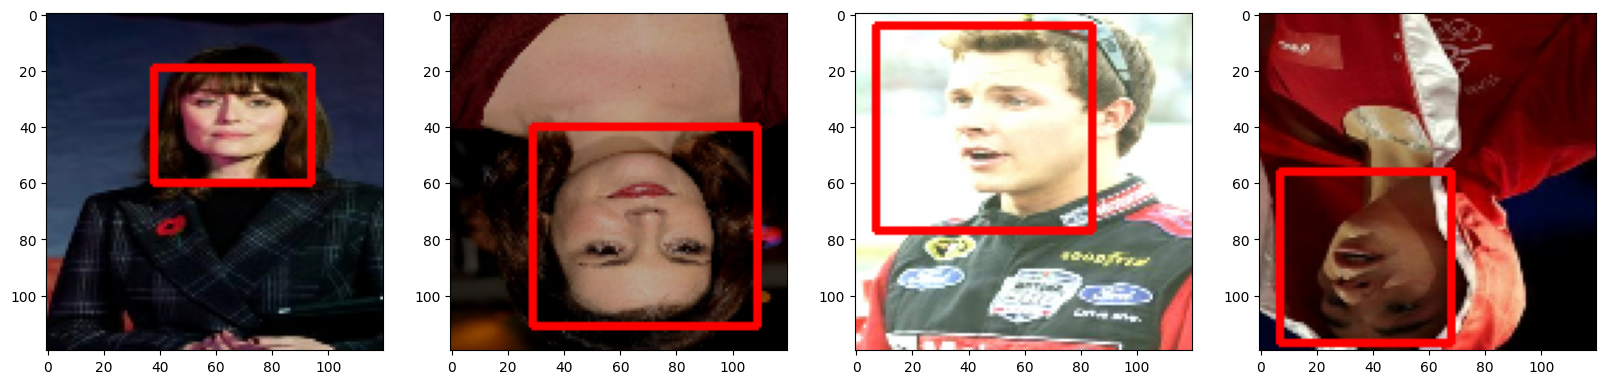

In [63]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

yhat = facetracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = cv2.cvtColor(test_sample[0][idx], cv2.COLOR_RGB2BGR)
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 9.2. Save the Model

In [64]:
from tensorflow.keras.models import load_model

In [65]:
facetracker.save('/kaggle/working/facetracker.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 9.3. Make predictions on your image

In [80]:
facetracker = load_model('/kaggle/working/facetracker.h5')

1/1 [==============================] - 0s 167ms/step


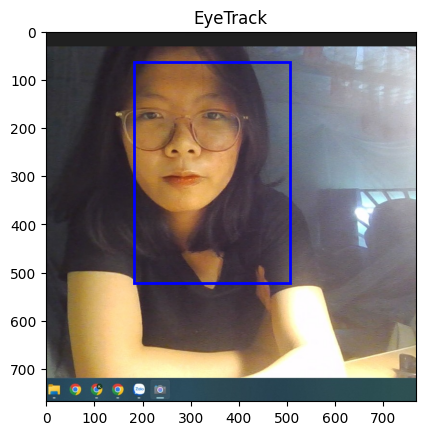

In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

file_path = '/kaggle/input/anh-test/339131092_231283026100348_966652214284936609_n.jpg'
# file_path = '/kaggle/input/dataset-for-face-detection/Dataset_LFPW/Dataset_LFPW/image_1000.jpg'
img = cv2.imread(file_path)

# # Display the image using plt.imshow
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.title('EyeTrack')

# Your processing code (resizing, predictions, rectangle drawing, text) goes here
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized = tf.image.resize(rgb, (120,120))

yhat = facetracker.predict(np.expand_dims(resized/255,0))
sample_coords = yhat[1][0]

# Define image_shape
image_shape = img.shape[:2]  # Get image shape (height, width)

# Calculate rectangle coordinates
rect_start_x = int(sample_coords[0] * image_shape[1])
rect_start_y = int(sample_coords[1] * image_shape[0])
rect_end_x = int(sample_coords[2] * image_shape[1])
rect_end_y = int(sample_coords[3] * image_shape[0])

# Create figure and axes
fig, ax = plt.subplots()

# Display the image using plt.imshow
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.set_title('EyeTrack')

# Draw the main rectangle
rect_width = rect_end_x - rect_start_x
rect_height = rect_end_y - rect_start_y
rect = plt.Rectangle((rect_start_x, rect_start_y), rect_width, rect_height,
                     linewidth=2, edgecolor='blue', facecolor='none')
ax.add_patch(rect)

# Show the plot
plt.show()


1/1 [==============================] - 0s 168ms/step


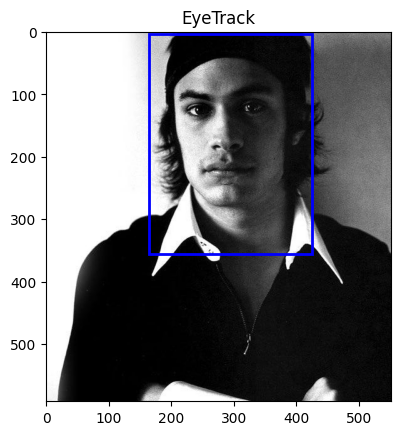

In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# file_path = '/kaggle/input/anh-test/339131092_231283026100348_966652214284936609_n.jpg'
file_path = '/kaggle/input/dataset-for-face-detection/Dataset_LFPW/Dataset_LFPW/image_1004.jpg'
img = cv2.imread(file_path)

# Your processing code (resizing, predictions, rectangle drawing, text) goes here
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized = tf.image.resize(rgb, (120,120))

yhat = facetracker.predict(np.expand_dims(resized/255,0))
sample_coords = yhat[1][0]

# Define image_shape
image_shape = img.shape[:2]  # Get image shape (height, width)

# Calculate rectangle coordinates
rect_start_x = int(sample_coords[0] * image_shape[1])
rect_start_y = int(sample_coords[1] * image_shape[0])
rect_end_x = int(sample_coords[2] * image_shape[1])
rect_end_y = int(sample_coords[3] * image_shape[0])

# Create figure and axes
fig, ax = plt.subplots()

# Display the image using plt.imshow
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.set_title('EyeTrack')

# Draw the main rectangle
rect_width = rect_end_x - rect_start_x
rect_height = rect_end_y - rect_start_y
rect = plt.Rectangle((rect_start_x, rect_start_y), rect_width, rect_height,
                     linewidth=2, edgecolor='blue', facecolor='none')
ax.add_patch(rect)

# Show the plot
plt.show()


### 11.3 Crop

1/1 [==============================] - 0s 32ms/step


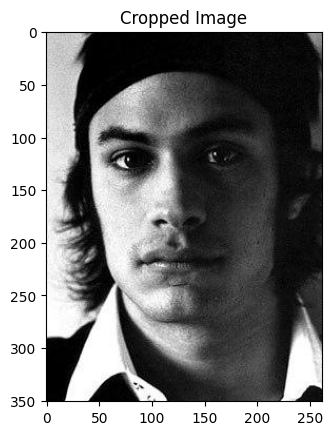

True

In [82]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

file_path = '/kaggle/input/dataset-for-face-detection/Dataset_LFPW/Dataset_LFPW/image_1004.jpg'
img = cv2.imread(file_path)

rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized = tf.image.resize(rgb, (120, 120))

yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
sample_coords = yhat[1][0]

# Get image shape for calculating coordinates
image_shape = img.shape[:2]

# Assuming 'image' is your loaded image and the coordinates are in pixel values
x_min = int(sample_coords[0] * image_shape[1])
y_min = int(sample_coords[1] * image_shape[0])
x_max = int(sample_coords[2] * image_shape[1])
y_max = int(sample_coords[3] * image_shape[0])

# Ensure coordinates are integers
x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])

# Crop the image based on the bounding box coordinates
cropped_img = img[y_min:y_max, x_min:x_max]

# Display the cropped image
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image')
plt.show()

# Save the cropped image
cv2.imwrite('/kaggle/working/cropped_image.jpg', cropped_img)
